In [1]:
import SBP as sb 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
from SBP.legendre import lgl, lagrange
np.set_printoptions(linewidth=np.inf)

In [6]:
class Element1D:
    """
    1D element for nodal DG / SBP methods.
    Uses Legendre-Gauss-Lobatto (LGL) nodes and maps reference [-1,1] to physical [left,right].
    """
    def __init__(self, index: int, left: float, right: float, n: int):
        self.index = index
        self.left = left
        self.right = right
        self.n = n
        # reference nodes xi and weights (we only need xi)
        xi, _ = lgl(n)
        self.xi = np.array(xi).flatten()
        # physical coordinates
        self.x = ( (self.right - self.left)/2 ) * self.xi + (self.right + self.left)/2
        # Jacobian for mapping
        self.jacobian = (self.right - self.left)/2
        # placeholder for solution values at nodes
        self.solution = np.zeros(n+1)

    def set_solution(self, sol: np.ndarray):
        """Assign solution values at the element's nodes."""
        assert sol.shape == (self.n+1,)
        self.solution = sol.copy()

    def map_to_reference(self, x_phys: float) -> float:
        """Map a physical coordinate back to reference xi in [-1,1]."""
        return (2*x_phys - (self.left + self.right)) / (self.right - self.left)

    def basis_at(self, x_phys: float) -> np.ndarray:
        """Evaluate all Lagrange basis polynomials at a physical point."""
        xi = self.map_to_reference(x_phys)
        return lagrange(self.n, xi)


class Mesh1D:
    """
    1D mesh composed of equally spaced Element1D objects.
    """
    def __init__(self, x_min: float, x_max: float, nex: int, n: int):
        self.x_min = x_min
        self.x_max = x_max
        self.nex = nex
        self.n = n
        self.elements = []
        self.generate_mesh()

    def generate_mesh(self):
        """Partition [x_min,x_max] into nex elements and create Element1D instances."""
        dx = (self.x_max - self.x_min) / self.nex
        for i in range(self.nex):
            left = self.x_min + i*dx
            right = left + dx
            elem = Element1D(i, left, right, self.n)
            self.elements.append(elem)

    def get_element(self, idx: int) -> Element1D:
        """Retrieve element by index."""
        return self.elements[idx]

    def set_solutions(self, U: np.ndarray):
        """Assign solution array U of shape (nex, n+1) to all elements."""
        assert U.shape == (self.nex, self.n+1)
        for i, elem in enumerate(self.elements):
            elem.set_solution(U[i])

    def global_coordinates(self) -> np.ndarray:
        """Return sorted unique global node coordinates."""
        coords = []
        for elem in self.elements:
            coords.extend(elem.x.tolist())
        return np.unique(coords)

    def plot_mesh(self):
        """Simple plot of the mesh nodes and element edges."""
        import matplotlib.pyplot as plt
        X = self.global_coordinates()
        Y = np.zeros_like(X)
        plt.figure(figsize=(8,1))
        plt.plot(X, Y, 'o')
        for elem in self.elements:
            plt.plot(elem.x, np.zeros_like(elem.x), '-')
        plt.yticks([])
        plt.title(f"1D Mesh: {self.nex} elements, degree {self.n}")
        plt.xlabel("x")
        plt.show()

In [10]:
e = Element1D(1, 0, 10, 5)
e.jacobian

5.0

In [2]:
d1 = sb.sbp_d(5)
p1 = sb.sbp_p(5)
print([np.sum(d1[i][:]) for i in range(len(d1[0][:]))]), d1


[-8.881784197001252e-16, -2.7755575615628914e-17, -5.551115123125783e-17, 5.551115123125783e-17, 0.0, 0.0]


(None,
 array([[ 7.50000000e+00, -1.01414159e+01,  4.03618727e+00, -2.24468465e+00,  1.34991331e+00, -5.00000000e-01],
        [ 1.78636495e+00, -1.50712776e-14, -2.52342678e+00,  1.15282816e+00, -6.53547507e-01,  2.37781178e-01],
        [-4.84951048e-01,  1.72125695e+00,  9.43689571e-16, -1.75296197e+00,  7.86356672e-01, -2.69700611e-01],
        [ 2.69700611e-01, -7.86356672e-01,  1.75296197e+00, -2.27595720e-15, -1.72125695e+00,  4.84951048e-01],
        [-2.37781178e-01,  6.53547507e-01, -1.15282816e+00,  2.52342678e+00,  1.77635684e-14, -1.78636495e+00],
        [ 5.00000000e-01, -1.34991331e+00,  2.24468465e+00, -4.03618727e+00,  1.01414159e+01, -7.50000000e+00]]))

In [2]:
#####
# 1 - P is SPD 
#####
n = 5
P = sb.sbp_p(n)
tol = 1e-14
print(P)
assert np.allclose(P, P.T, atol=tol),      "P not symmetric"
assert np.allclose(P - np.diag(np.diag(P)), 0, atol=tol), "P has off-diagonals"
assert np.all(np.diag(P) > 0),             "Some P[ii] <= 0"


[[0.06666667 0.         0.         0.         0.         0.        ]
 [0.         0.37847496 0.         0.         0.         0.        ]
 [0.         0.         0.55485838 0.         0.         0.        ]
 [0.         0.         0.         0.55485838 0.         0.        ]
 [0.         0.         0.         0.         0.37847496 0.        ]
 [0.         0.         0.         0.         0.         0.06666667]]


In [3]:
#####
# 2 -  P performs Exact Integration (Up to Machine Percision)
#####
n = 5
p = 6
roots = np.zeros(n+1)
out   = np.zeros(n+1)
roots[:] = sb.lgl(n)[0][:]
out[:]   = sb.lgl(n)[1][:]
np.sum(out@np.power(roots,p)), 2/(p+1)

(0.2857142857142865, 0.2857142857142857)

In [4]:
#####
# 3 - Sum of weights = 2
#####
w = out
assert abs(np.sum(w) - 2) < tol, "∑wᵢ ≠ 2"

In [5]:
#####
# 4 - D row sums are = 0 
#####
n = 5
D = sb.sbp_d(n)
assert np.allclose(D.sum(axis=1), 0, atol=tol), "Rows of D do not sum to zero"


(5,)
[[-5.00000000e+00  6.75650249e+00 -2.66666667e+00  1.41016418e+00 -5.00000000e-01]
 [-1.24099025e+00  7.21644966e-16  1.74574312e+00 -7.63762616e-01  2.59009747e-01]
 [ 3.75000000e-01 -1.33658458e+00 -3.88578059e-16  1.33658458e+00 -3.75000000e-01]
 [-2.59009747e-01  7.63762616e-01 -1.74574312e+00  4.44089210e-16  1.24099025e+00]
 [ 5.00000000e-01 -1.41016418e+00  2.66666667e+00 -6.75650249e+00  5.00000000e+00]]
[-1.5, -0.9819805060619657, 0.0, 0.9819805060619656, 1.5] /n [1.5 1.5 1.5 1.5 1.5]


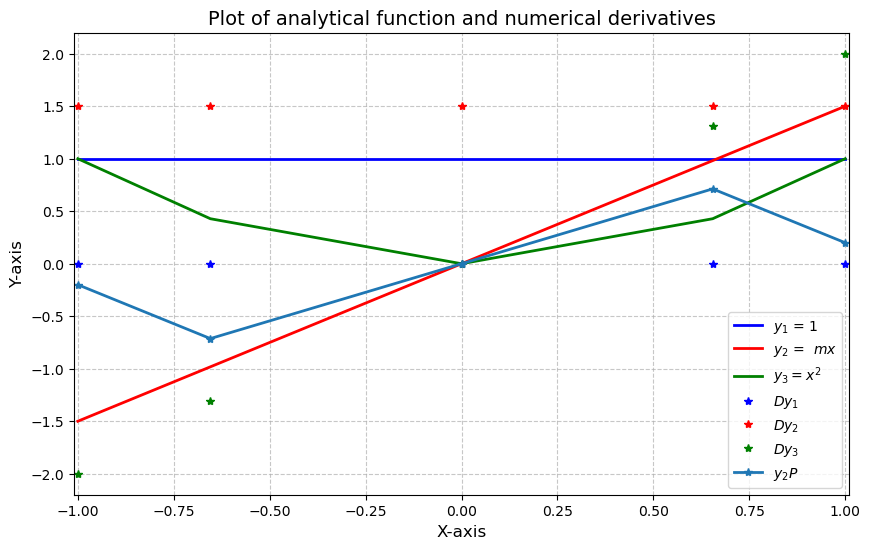

In [6]:
#####
# 5 - D polynomial differentiation
#####

### Setting up the colocation points 
n = 4 # poly nomial order
x = np.zeros(n+1) # Initialization
x[:] = sb.lgl(n)[0,:]

### Setting up analytic functions 
y_1 = np.ones_like(x)
print(np.shape(y_1))
# Defining a linear functions
m = 1.5
y_2 = [m*x[i] for i in range(n+1)]
y_3 = [x[i]**2 for i in range(n+1)]



### Numerical Differentiation 
D = sb.sbp_d(n)
P = sb.sbp_p(n)
print(D)
#print([np.sum(D[i,:]) for i in range(n+1)])
print(y_2 , "/n", D@y_2)
# 
# 
# P 
y_1_d = D@y_1
y_2_d = D@y_2
y_3_d = D@y_3

#Testing the P Matrix As well
y_2_p = P@np.transpose(y_3_d)
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Create figure with specified size

# Plot the data
ax.plot(x, y_1, 'b-', linewidth=2, label="$y_1$ = 1")
ax.plot(x, y_2, 'r-', linewidth=2, label="$y_2$ =  $mx$")
ax.plot(x, y_3, 'g-', linewidth=2, label="$y_3= x^2$")
ax.plot(x, y_1_d, 'b*', linewidth=2, label="$Dy_1$")
ax.plot(x, y_2_d, 'r*', linewidth=2, label="$Dy_2$")
ax.plot(x, D@y_3, 'g*', linewidth=2, label="$Dy_3$")
ax.plot(x, y_2_p, '*-', linewidth=2, label="$y_2P$")
# Set plot labels and title
ax.set_xlabel('X-axis', fontsize=12)
ax.set_ylabel('Y-axis', fontsize=12)
ax.set_title('Plot of analytical function and numerical derivatives', fontsize=14)

# Add grid, legend and set axis limits
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10)
ax.set_xlim([-1.01, 1.01])
ax.set_ylim([-2.2, 2.2])
plt.show()

In [7]:
#####
# 6 - Q, Skew-symmetric form
#####


#Matrix P
n = 5
out = sb.lgl(n)
roots = np.zeros(n+1)
w = np.zeros(n+1)
w[:] = out[1,:]
roots[:] = out[0,:]
P = sb.sbp_p(n)

D = sb.sbp_d(n)

#Matrix Q from P
dq = sb.sbp_d(n)
result1 = np.zeros_like(P)
for i in range(n+1):
    result1[:,i] = sb.lagrange(n,roots[i]) @dq*w[i]
result1 = result1  
Q = result1
print("The matrix Q from P \n", Q) 

B = np.zeros_like(P)
B[0,0]   = -1
B[-1,-1] =  1
tol = 1e-12
assert np.allclose(Q + Q.T, B, atol=tol), "SBP condition Q+Qᵀ=B failed"
B, Q + Q.T

The matrix Q from P 
 [[-5.00000000e-01 -6.76094396e-01  2.69079151e-01 -1.49645643e-01  8.99942209e-02 -3.33333333e-02]
 [ 6.76094396e-01  5.70410112e-15 -9.55053839e-01  4.36316587e-01 -2.47351364e-01  8.99942209e-02]
 [-2.69079151e-01  9.55053839e-01 -5.23614064e-16 -9.72645632e-01  4.36316587e-01 -1.49645643e-01]
 [ 1.49645643e-01 -4.36316587e-01  9.72645632e-01  1.26283392e-15 -9.55053839e-01  2.69079151e-01]
 [-8.99942209e-02  2.47351364e-01 -4.36316587e-01  9.55053839e-01 -6.72306577e-15 -6.76094396e-01]
 [ 3.33333333e-02 -8.99942209e-02  1.49645643e-01 -2.69079151e-01  6.76094396e-01  5.00000000e-01]]


(array([[-1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]),
 array([[-1.00000000e+00, -3.21964677e-15,  2.33146835e-15, -1.36002321e-15,  5.27355937e-16,  6.93889390e-18],
        [-3.21964677e-15,  1.14082022e-14, -3.77475828e-15,  1.94289029e-15, -2.49800181e-16, -4.57966998e-16],
        [ 2.33146835e-15, -3.77475828e-15, -1.04722813e-15, -7.77156117e-16, -1.11022302e-15,  1.30451205e-15],
        [-1.36002321e-15,  1.94289029e-15, -7.77156117e-16,  2.52566784e-15,  3.44169138e-15, -2.66453526e-15],
        [ 5.27355937e-16, -2.49800181e-16, -1.11022302e-15,  3.44169138e-15, -1.34461315e-14,  4.21884749e-15],
        [ 6.93889390e-18, -4.57966998e-16,  1.30451205e-15, -2.66453526e-15,  4.21884749e-15,  1.00000000e+00]]))

In [8]:
B = np.zeros_like(P)
B[0,0]   = -1
B[-1,-1] =  1
tol = 1e-12
Q = sb.sbp_q(n)
assert np.allclose(Q + Q.T, B, atol=tol), "SBP condition Q+Qᵀ=B failed"
B, Q + Q.T

(array([[-1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.]]),
 array([[-1.00000000e+00, -3.21964677e-15,  2.33146835e-15, -1.36002321e-15,  5.27355937e-16,  6.93889390e-18],
        [-3.21964677e-15,  1.14082022e-14, -3.77475828e-15,  1.94289029e-15, -2.49800181e-16, -4.57966998e-16],
        [ 2.33146835e-15, -3.77475828e-15, -1.04722813e-15, -7.77156117e-16, -1.11022302e-15,  1.30451205e-15],
        [-1.36002321e-15,  1.94289029e-15, -7.77156117e-16,  2.52566784e-15,  3.44169138e-15, -2.66453526e-15],
        [ 5.27355937e-16, -2.49800181e-16, -1.11022302e-15,  3.44169138e-15, -1.34461315e-14,  4.21884749e-15],
        [ 6.93889390e-18, -4.57966998e-16,  1.30451205e-15, -2.66453526e-15,  4.21884749e-15,  1.00000000e+00]]))

In [9]:
################
##### Entropy Flux Function - Done 
################

n = 3 ## Testing degree 
out = lgl(n)
roots, w = np.zeros(n+1),np.zeros(n+1)
roots[:], w[:] = out 
D = sb.sbp_d(n)
P = sb.sbp_p(n)
Q = sb.sbp_q(n)

u = np.array([1,2,3,4]) # Testing with a dummy value 

F = np.zeros((n+1,n+1))
for j in range(n+1): 
    for i in range(n+1): 
        F[i][j] = (1/6)*(u[i]**2 + u[i]*u[j] + u[j]**2)
print(F)



def two_point_flux_function(n, D, u): 
    ## Using numpy broadcasting is much faster than loops 
    ui = u[:,None]
    uj = u[None,:]
    F = np.zeros((n+1,n+1)) 
    F = (1/6)*(ui**2 + ui*uj + uj**2)
    return 2*np.multiply(D,F)

[[0.5        1.16666667 2.16666667 3.5       ]
 [1.16666667 2.         3.16666667 4.66666667]
 [2.16666667 3.16666667 4.5        6.16666667]
 [3.5        4.66666667 6.16666667 8.        ]]


In [10]:
two_point_flux_function(n,D,u)

array([[-3.00000000e+00,  9.43853160e+00, -6.69536821e+00,  3.50000000e+00],
       [-1.88770632e+00, -6.66133815e-16,  7.08088193e+00, -2.88415861e+00],
       [ 1.33907364e+00, -7.08088193e+00, -2.99760217e-15,  9.97787626e+00],
       [-3.50000000e+00,  1.44207931e+01, -4.98893813e+01,  4.80000000e+01]])

In [ ]:
class Element1D:
    """
    A 1D element that only stores:
      - left/right physical coords
      - reference nodes xi
      - reference SBP matrices D_ref, P_ref
    and computes its Jacobian & physical‐space operators once, at __init__.
    """
    def __init__(self,
                 index: int,
                 left: float,
                 right: float,
                 xi: np.ndarray,      # reference nodes
                 D_ref: np.ndarray,   # reference D
                 P_ref: np.ndarray,
                 Q_ref: np.ndarray):  # reference P
        self.index   = index
        self.left    = left
        self.right   = right
        self.xi      = xi        # shape (n+1,)
        self.n       = xi.size-1

        # ----------------------------------> 
        self.el      = np.eye(self.n + 1)[0]
        self.er      = np.eye(self.n + 1)[-1]
        self.irhs    = np.zeros_like(u) # This is the interior RHS without element coupling
        # ---------------------------------->
        # physical nodes: x(ξ) = h*ξ + c
        h         = (right - left)/2
        c         = (right + left)/2
        self.x    = h*xi + c     # shape (n+1,)

        # Jacobian & scaled SBP
        self.J        = h
        self.D_ref    = D_ref
        self.P_ref    = P_ref
        self.Q_ref    = Q_ref
        # physical‐space SBP operators:
        self.D_phys = D_ref / h         # ∂/∂x = (1/J) ∂/∂ξ
        self.P_phys = P_ref * h         # ∫_x = ∫_ξ J dξ
        self.Q_phys = self.P_phys.dot(self.D_phys) # Notice the use of the physical operators 
        self.P_inv  = np.linalg.inv(self.P_ref)

        # placeholder for solution in reference space
        self.u = np.zeros(self.n+1)

    def left_boundary(self): 
        return self.u[0] # This should select the left boundary node
    
    def right_boundary(self): 
        return self.u[-1] # This should select the left boundary node
    


    def set_solution_reference(self, u_ref: np.ndarray):
        """Set the nodal values on reference nodes."""
        assert u_ref.shape == (self.n+1,)
        self.u = u_ref.copy()

    def solution_physical(self) -> np.ndarray:
        """
        Since values are stored at the same nodes,
        U_phys(x_i) = U_ref(xi_i).
        """
        return self.u
    
    def set_initial_condition(self, f):
        """ In: f - function that is callable. 
    """
        u_0 = np.zeros(self.n+1)
        u_0 = f(self.x)
        self.u = u_0

    def map_to_reference(self, x_phys: float) -> float:
        return (2*x_phys - (self.left + self.right))/(self.right - self.left)

    def map_to_physical(self, xi: float) -> float:
        return ( (self.right - self.left)/2 )* xi + (self.right + self.left)/2
    
    def plot(self, ax=None):
        """
        Plot this element’s nodal solution using its own style.
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,3))
            ax.set_xlabel("x")
            ax.set_ylabel("u")
            ax.grid(True)
            ax.set_title("Solution per element")

        ax.plot(self.x, self.u)
        ax.grid(True)
        return ax


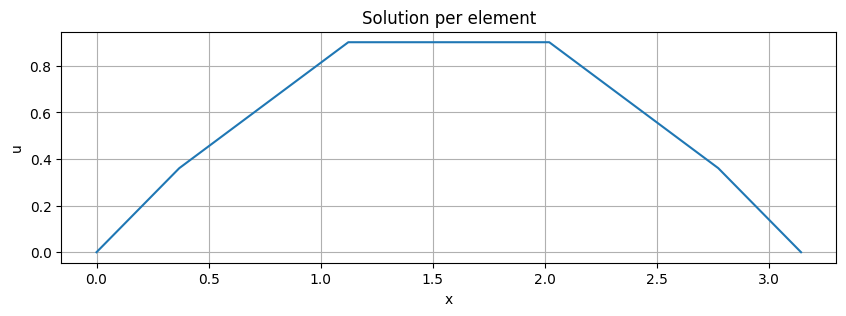

In [7]:
n = 5
D = sb.sbp_d(n)
P = sb.sbp_p(n)
Q = sb.sbp_q(n)
xi, out = lgl(n)
xi,out 
l = 0 
r = np.pi
L = r - l 

e1 = Element1D(0,l,r,xi,D,P,Q)

def initial_condition(x, L=1): 
    return np.sin(x/L)


e1.u, e1.set_initial_condition(initial_condition)
ax = e1.plot()
plt.show()


In [3]:


class Mesh1D:
    """
    1D mesh composed of equally spaced Element1D objects,
    with all SBP operators provided externally.
    """
    def __init__(self,
                 x_min: float,
                 x_max: float,
                 nex: int,
                 n: int,
                 xi: np.ndarray,
                 w: np.ndarray,
                 D_ref: np.ndarray,
                 P_ref: np.ndarray,
                 Q_ref: np.ndarray):
        """
        Initialize the mesh and its elements.

        Parameters
        ----------
        x_min, x_max : float
            Physical domain endpoints.
        nex : int
            Number of elements.
        n : int
            Polynomial degree (n+1 LGL nodes per element).
        xi : np.ndarray
            Reference nodes (length n+1).
        w : np.ndarray
            Reference weights (length n+1).
        D_ref : np.ndarray
            Differentiation matrix on reference.
        P_ref : np.ndarray
            Norm (quadrature) matrix on reference.
        Q_ref : np.ndarray
            Skew-symmetric SBP matrix on reference.
        """
        # store mesh parameters
        self.x_min, self.x_max = x_min, x_max
        self.nex, self.n       = nex, n

        # store reference SBP data
        self.xi    = xi.copy()
        self.w     = w.copy()
        self.D_ref = D_ref.copy()
        self.P_ref = P_ref.copy()
        self.Q_ref = Q_ref.copy()

        # build physical elements
        self.elements = []
        dx = (self.x_max - self.x_min) / self.nex
        for i in range(self.nex):
            L = self.x_min + i * dx
            R = L + dx
            elem = Element1D(
                index=i,
                left=L,
                right=R,
                xi=self.xi,
                D_ref=self.D_ref,
                P_ref=self.P_ref,
                Q_ref=self.Q_ref
            )
            self.elements.append(elem)

    def set_initial_condition(self, f):
        """
        Apply an initial-condition function f(x_phys) to every element.

        f may be vectorized (accept a NumPy array) or scalar-only.
        If f(x_phys) raises an exception, fallback to scalar loop.

        After calling this, each element's reference solution is set
        to f evaluated at its physical nodes.
        """
        for elem in self.elements:
            x_phys = elem.x
            try:
                u0 = f(x_phys)
            except Exception:
                u0 = np.array([f(x) for x in x_phys])
            elem.set_solution_reference(u0)

    def set_solution(self, U: np.ndarray):
        """
        Assign a full solution array to mesh elements.

        U must have shape (nex, n+1).
        """
        assert U.shape == (self.nex, self.n+1), \
            f"Expected U shape ({self.nex},{self.n+1}), got {U.shape}"
        for elem, u_row in zip(self.elements, U):
            elem.set_solution_reference(u_row)

    def global_coordinates(self) -> np.ndarray:
        """
        Return sorted unique global node coordinates across elements.
        """
        coords = []
        for elem in self.elements:
            coords.extend(elem.x.tolist())
        return np.unique(coords)
    
    
    def x(self) -> np.ndarray:
        """
        Return a 2D NumPy array of physical node coordinates for each element.

        Output shape is (nex, n+1), where each row gives `elem.x`.
        """
        # Stack each element's x array into a 2D array
        return np.vstack([elem.x for elem in self.elements])

    def plot(self,
             ax=None,
             edge_opts=None,
             node_opts=None,
             boundary_opts=None,
             figsize=None):
        """
        Draw the mesh edges, nodes, and element boundaries on the given Axes.

        Parameters
        ----------
        ax : matplotlib.axes.Axes, optional
            Axes to draw on. If None, creates new figure if figsize provided or uses plt.gca().
        edge_opts : dict, optional
            Style for element edges.
        node_opts : dict, optional
            Style for element nodes.
        boundary_opts : dict, optional
            Style for element boundary lines.
        figsize : tuple, optional
            Figure size (width, height) in inches, used only if ax is None to create a new figure.

        Returns
        -------
        ax : matplotlib.axes.Axes
            The Axes with the mesh drawn.
        """
        # create new figure/axes if none provided
        if ax is None:
            if figsize is not None:
                fig, ax = plt.subplots(figsize=figsize)
            else:
                ax = plt.gca()

        # default styles
        edge_defaults = {"linestyle": "-", "linewidth": 1, "color": "k"}
        node_defaults = {"marker": "o", "linestyle": "", "color": "C0"}
        boundary_defaults = {"linestyle": "--", "linewidth": 1, "color": "gray"}

        eopts = {**edge_defaults, **(edge_opts or {})}
        nopts = {**node_defaults, **(node_opts or {})}
        bopts = {**boundary_defaults, **(boundary_opts or {})}

        # plot element edges and nodes
        for elem in self.elements:
            x = elem.x
            y = np.zeros_like(x)
            ax.plot(x, y, **eopts)
            ax.plot(x, y, **nopts)
            ax.set_title("Mesh Nodes")
            ax.set_xlabel("x - coordinate")
            ax.set_ylabel("u")
        # plot element boundaries
        ymin, ymax = ax.get_ylim()
        for elem in self.elements:
            #ax.plot([elem.left, elem.left], [ymin, ymax], **bopts)
            ax.axvline(elem.left, **bopts) # This makes sure that the boundary lines span to the maximum edges of the figure
            ax.axvline(elem.right, **bopts) # This makes sure that the boundary lines span to the maximum edges of the figure
        ax.plot([self.x_max, self.x_max], [ymin, ymax], **bopts)

        return ax


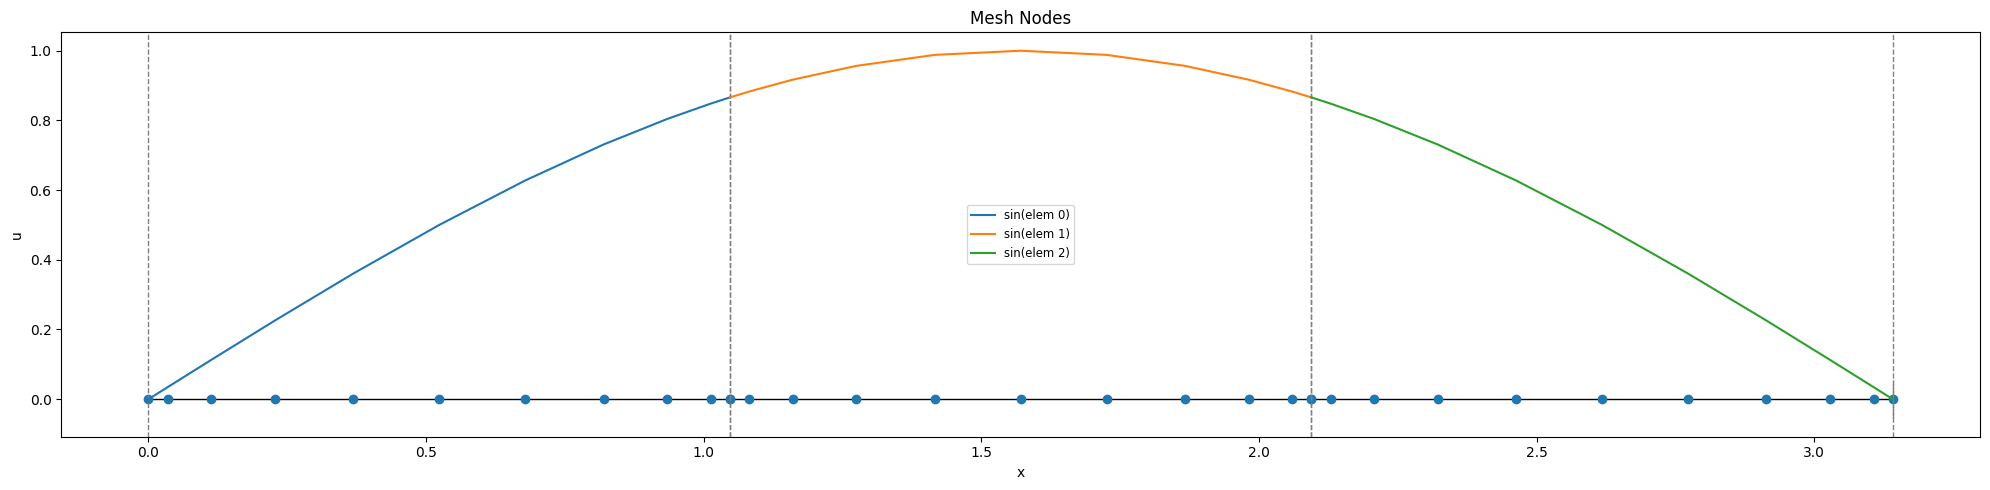

(3, 11)

In [4]:
n = 10
D = sb.sbp_d(n)
P = sb.sbp_p(n)
Q = sb.sbp_q(n)
xi, out = lgl(n)
xi,out 
l = 0 
r = np.pi
L = r - l 
nex = 3


fig, ax = plt.subplots(figsize=(20,5))
m1 = Mesh1D(l,r,nex, n, xi,out,D,P,Q)
m1.plot(ax=ax)

#test = np.sin(m1.x())
#ax.plot(m1.x(), test)


for idx, elem in enumerate(m1.elements):
    x_phys = elem.x
    y_sin = np.sin(x_phys)
    ax.plot(x_phys, y_sin, label=f"sin(elem {idx})")

ax.set_xlabel("x")
ax.set_ylabel("u")
ax.legend(fontsize="small")
plt.tight_layout()
plt.show()

plt.show()

m1.x().shape

<Figure size 640x480 with 0 Axes>